# Alcance

El presente documento tendrá como objetivo la elaboración de un modelo de Machine Learning que, dada una reseña, permita clasificarla en un puntaje del 1 al 5. Para esto, cuento con 3 datasets con reseñas existentes y sus respectivas clasificaciones.

En primer lugar, se realizará una exploración del dataset para un entendimiento más exhaustivo de las características del mismo. Luego se preprocesarán las reseñas para poder trabajar más fácilmente con ellas para, finalmente, encontrar el mejor modelo de Machine Learning que permita realizar este problema de clasificación con nuevos datos.

Finalmente, se realizará un análisis de las conclusiones obtenidas y un meta-análisis de la metodología aplicada.

In [1]:
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import random

import es_core_news_sm

from collections import Counter
import itertools
from wordcloud import WordCloud

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

# A - Exploración de datos y Procesamiento del Lenguaje Natural

## EDA

Tanto el dataset de formación como el de prueba cuentan con <code>5000 reseñas</code>, mientras que el de entrenamiento posee <code>200.000 reseñas</code>

In [3]:
print(df.shape)
print(df_test.shape)
print(df_train.shape)

(5000, 8)
(5000, 8)
(200000, 8)


Cada reseña cuenta con 7 atributos:
- ID de reseña (<code>review_id</code>)
- ID de producto (<code>product_id</code>)
- ID de evaluador (<code>reviewer_id</code>)
- Estrellas (<code>stars</code>)
- Cuerpo de reseña (<code>review_body</code>)
- Título de reseña (<code>review_title</code>)
- Idioma (<code>language</code>)
- Categoría de producto (<code>product_category</code>)

Ninguno de los cuales posee valores faltantes

In [4]:
print(df.info())
print(df_test.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   in

Al mirar muy superficialmente el dataset me surgen algunas preguntas que quisiera responder:
- ¿Todas las reseñas son realizadas en el mismo idioma?
- ¿Con qué cantidad de categorías cuenta el dataset? ¿Todas cuentan con la misma cantidad de reseñas?
- ¿La gente puntúa más los productos con mejor o peor puntaje?
- ¿Cuáles son las categorías que reciben mayor número de reseñas? ¿Cuáles son las más criticadas y las que reciben mejores puntajes?
- ¿Cuáles son las palabras más comunes para cada puntaje en las reseñas?

La totalidad de las reseñas se encuentran en idioma español

In [5]:
print(df['language'].unique())
print(df_test['language'].unique())
print(df_train['language'].unique())

['es']
['es']
['es']


De acuerdo con lo expresado en la página de descarga de este dataset ([Link](https://registry.opendata.aws/amazon-reviews-ml/)), todas las reseñas fueron recolectadas entre el **1 de noviembre 2015** y el **1 de noviembre 2019**

Dado que para explorar el dataset completo resulta difícil trabajar con los 3 por separado, los concatenaré a continuación

In [6]:
df_amazon = pd.concat([df,df_test,df_train],axis=0)
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  
0                         Mala compra       es          wireless  
1                   No lo he recibido       es           apparel  
2  Que no aprieta bien en el manillar       es            sports  
3               Brocas de mantequilla       es  home_improvement  
4                         No me gusta       es            beauty

In [7]:
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  
0                         Mala compra       es          wireless  
1                   No lo he recibido       es           apparel  
2  Que no aprieta bien en el manillar       es            sports  
3               Brocas de mantequilla       es  home_improvement  
4                         No me gusta       es            beauty

Puedo observar del siguiente gráfico que cada puntaje posee la misma cantidad de reseñas asociadas, lo que implica que el mismo está *balanceado*

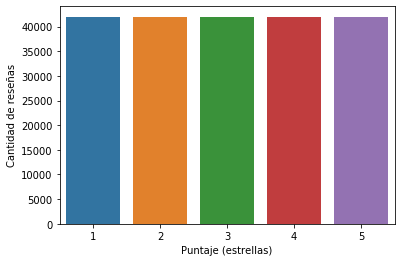

In [8]:
sns.countplot(x = 'stars', data = df_amazon)
plt.ylabel('Cantidad de reseñas')
plt.xlabel('Puntaje (estrellas)')

plt.show()

In [9]:
print('Existen',str(len(df_amazon['product_category'].unique())),'categorías únicas en el presente dataset')

Existen 30 categorías únicas en el presente dataset


Podemos observar que predominan las reseñas de productos línea **hogar** e **inalámbricos**, seguidos por **juguetes** y **deportes**

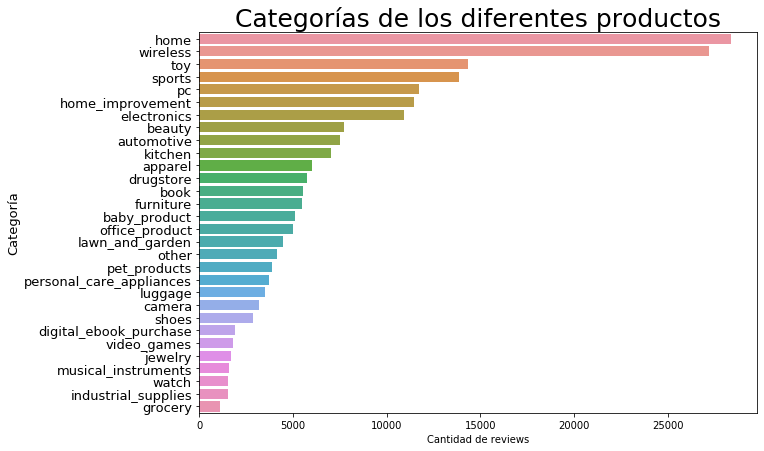

In [10]:
plt.figure(figsize = (10,7))

sns.countplot(y = 'product_category', 
              data = df_amazon,  
              order = df_amazon.product_category.value_counts().index)
plt.ylabel('Categoría',size=13)
plt.xlabel('Cantidad de reseñas')
plt.tick_params(axis='y', labelsize=13)
plt.title('Frecuencia de reseñado por categoría', size=25)
plt.show()

Las 3 mejores categorías más elogiadas son <code>books</code> (libros), <code>digital_ebook_purchase</code> (libros digitales), <code>luggage</code> (equipaje), mientras que las 3 más criticadas son <code>apparel</code> (vestimenta), <code>wireless</code> (productos inalámbricos) y <code>lawn and garden</code> (césped y jardinería)

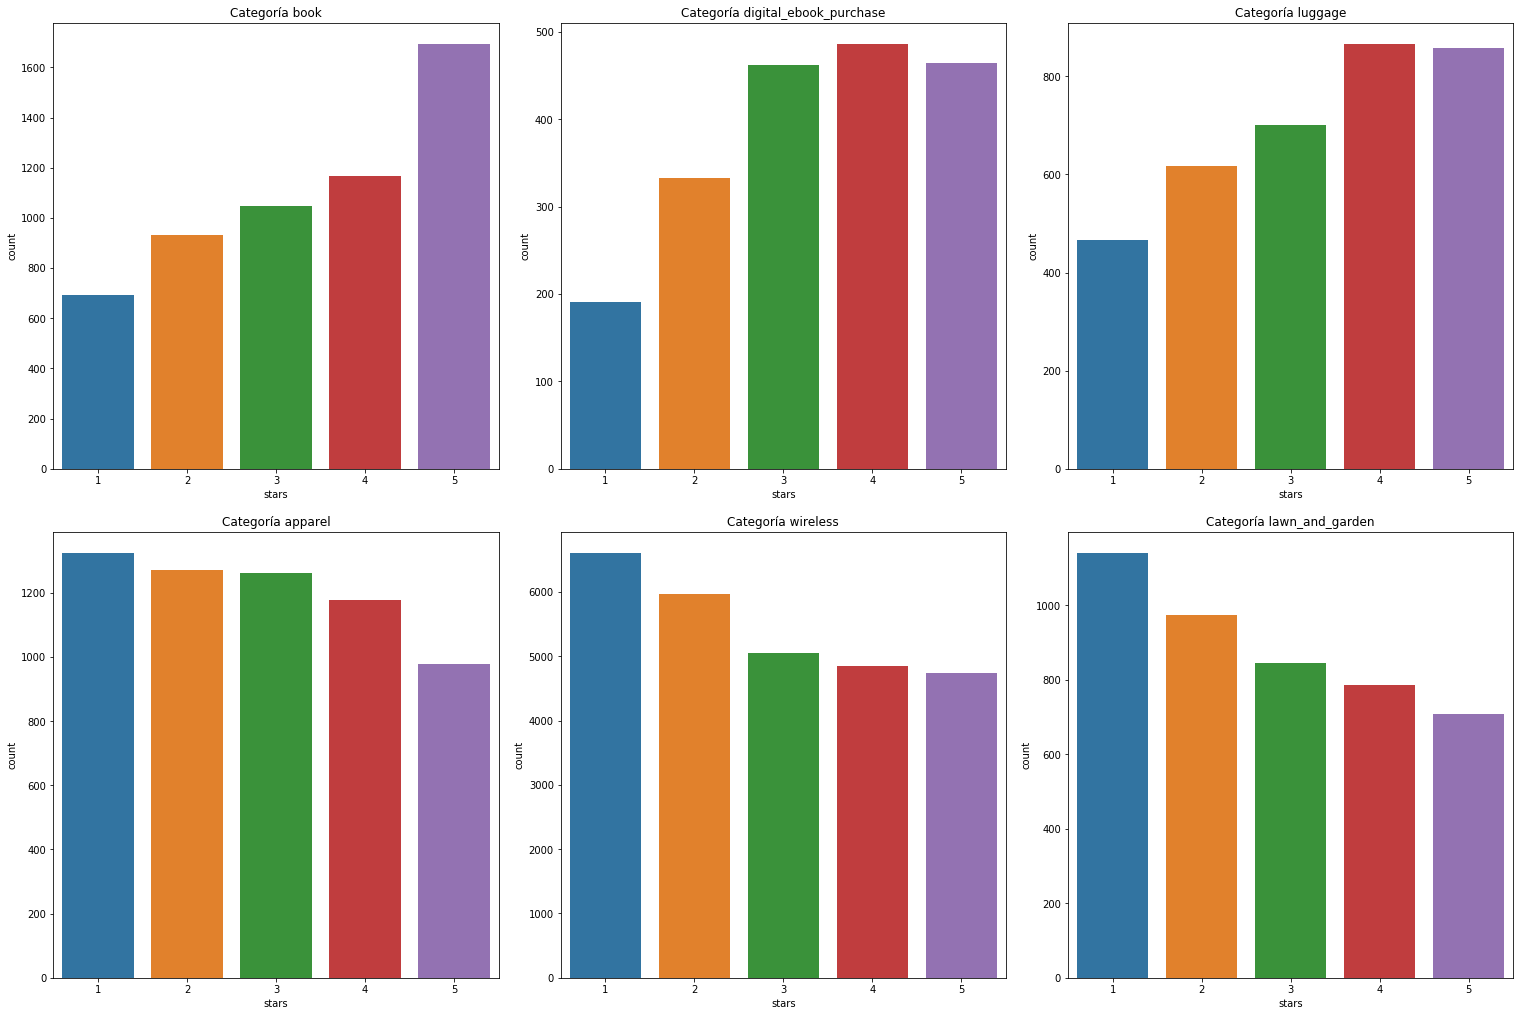

In [114]:
mean_p = df_amazon.groupby(['product_category'])[['stars']].mean().sort_values(by='stars', ascending=False)
primeros_tres = list(mean_p.iloc[:3].reset_index()['product_category'])
ultimos_tres = list(mean_p.iloc[27:].reset_index()['product_category'])
primeros_tres.extend(ultimos_tres)

num_plots = len(primeros_tres)
total_cols = 3
total_rows = num_plots//total_cols

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)


for i, ax in enumerate(axs.flatten()):
    row = i//total_cols
    pos = i % total_cols
    sns.countplot(x='stars', data=df_amazon[df_amazon['product_category']== primeros_tres[i]], ax=axs[row][pos])
    ax.set_title('Categoría {}'.format(primeros_tres[i]))
plt.show()

## Preprocesamiento de las reseñas

A continuación y con el motivo de poder analizar más fácilmente las reseñas, uniré en una misma columna <code>review_entero</code> las reseñas con sus títulos 

In [12]:
df_amazon['review_entero'] = df_amazon['review_title']+ ' ' + df_amazon['review_body']
df_amazon.reset_index(inplace=True,drop=True)
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  \
0                         Mala compra       es          wireless   
1                   No lo he recibido       es           apparel   
2  Que no aprieta bien en el manillar       es            sports   
3               Brocas de mantequilla       es  home_improvement   
4                         No me gusta       es            beauty   

                                       review_entero  
0  Mala compra Malisimo, muy grande demasiado apa...  
1  No lo he recibido No he recibido el pedido no ...  
2  Que no aprieta bien en el manillar Tengo que b...  
3  Brocas de mantequilla Utilicé las brocas de me...  
4  No me gusta No me gusta su olor a viejo y aspe...

En la siguiente celda:
- Cargaré el <code>pipeline</code> en español de <code>spaCy</code>. Este, como se puede observar en el diagrama de más abajo, aplica algunas transformaciones al texto que pasemos a través suyo. De acuerdo con la documentación del mismo, las transformaciones aplicadas son: <code>tok2vec</code>, <code>morphologizer</code>, <code>parser</code>, <code>ner</code>, <code>attribute_ruler</code> y <code>lemmatizer</code>

<img src="https://d33wubrfki0l68.cloudfront.net/3ad0582d97663a1272ffc4ccf09f1c5b335b17e9/7f49c/pipeline-fde48da9b43661abcdf62ab70a546d71.svg" alt="Drawing" style="width: 600px;"/>

- Cargaré las palabras comunes (stopwords) en español para luego filtrarlas

In [13]:
nlp = es_core_news_sm.load()

sw = nlp.Defaults.stop_words

A través de la siguiente función aplicaré <code>**normalizado**</code> al texto de cada fila. Esto incluye:
- El preprocesado mencionado anteriormente con <code>nlp</code>
- Todas las palabras pasarán a ser minúsculas
- Se eliminarán comas, puntos y palabras de 1 letra (por ejemplo "y", "a", etc)
- Se quitarán las <code>stopwords</code>. Estas son palabras que carecen de significado por sí solas, como preposiciones, artículos, conjunciones, pronombres, etc.

El objetivo de este preprocesamiento, que reducirá el ruido del texto al eliminar las formas infleccionales y a veces derivacionalmente relacionadas a una base común*, es facilitar el posterior análisis de cada reseña mediante algoritmos de clasificación. De esta forma, se podrán predecir con mayor precisión la cantidad de estrellas que daría a un producto un usuario dada una reseña

*"**Stemming and lemmatization", Stanford, Cambridge University Press, 2008, https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html**


McNary, Dave. “Keanu Reeves, Alex Winter Returning for ‘Bill and Ted Face the Music.’” Variety, Penske Media Corporation, 8 May 2018, variety.com/2018/film/news/bill-and-ted-3-keanu-reeves-alex-winter-1202802946/.

Si bien en la siguiente función el tokenizado y eliminación de stopwords de las primeras 2 líneas de la misma puede resultar redundante ya que esto es realizado posteriormente al llamar al pipeline de <code>spaCy</code>, esto se realizó de todas formas debido a que este malinterpreta palabras como "para" y las transforma en "parir", lo que afecta al resultado.

Realizando el filtrado de stopwords sin haber hecho el lemmatizado previo eliminará palabras como "para"

In [14]:
def procesar(texto):
    reseña_tk = nltk.RegexpTokenizer('\w+').tokenize(texto)
    reseña_tk_min = [word.lower() for word in reseña_tk if word.lower() not in sw]
    review_clean = ' '.join(reseña_tk_min)
    reseña_limpia = nlp(review_clean)
    reseña_lematizada = [word.lemma_ for word in reseña_limpia]
    reseña_lematizada = [t for t in reseña_lematizada if len(t)>1]
    return reseña_lematizada

A continuación, podemos ver un ejemplo de preprocesamiento:

In [15]:
x = 119
print("Texto sin procesar:")
print(df_amazon.review_entero[x])
print("----------------")
print("Texto procesado:")
print(procesar(df_amazon.review_entero[x]))

Texto sin procesar:
El producto no llegó Se inventaron la excusa más cutre para no enviarme el producto. Un terremoto hizo que no me llegara este producto.
----------------
Texto procesado:
['producto', 'inventar', 'excusa', 'cutre', 'enviar yo', 'producto', 'terremoto', 'llegar', 'producto']


Aplico esto a cada fila de la columna <code>review_entero</code>

In [16]:
df_amazon['review_entero_tk'] = df_amazon.apply(lambda row: procesar(row['review_entero']), axis=1)

Debido a que el preprocesamiento del dataset consume muchos recursos y por lo tanto lleva algunas horas de ejecución, guardo esta instancia en un archivo Excel para su posterior carga a modo de checkpoint

In [17]:
df_amazon.to_excel('Preprocesado.xlsx')

Demostraré mediante la siguiente función las 5 palabras más comunes de cada grupo de reseñas (agrupadas por cantidad de estrellas), imprimiré una nube de palabras para cada una y graficaré las 20 palabras más frecuentes en un gráfico de barras

5 palabras más comunes para críticas de 1 estrellas
    Palabras  Frecuencia
0   producto       10042
1    calidad        7094
2       malo        7042
3  funcionar        6664
4     llegar        4616
-------------


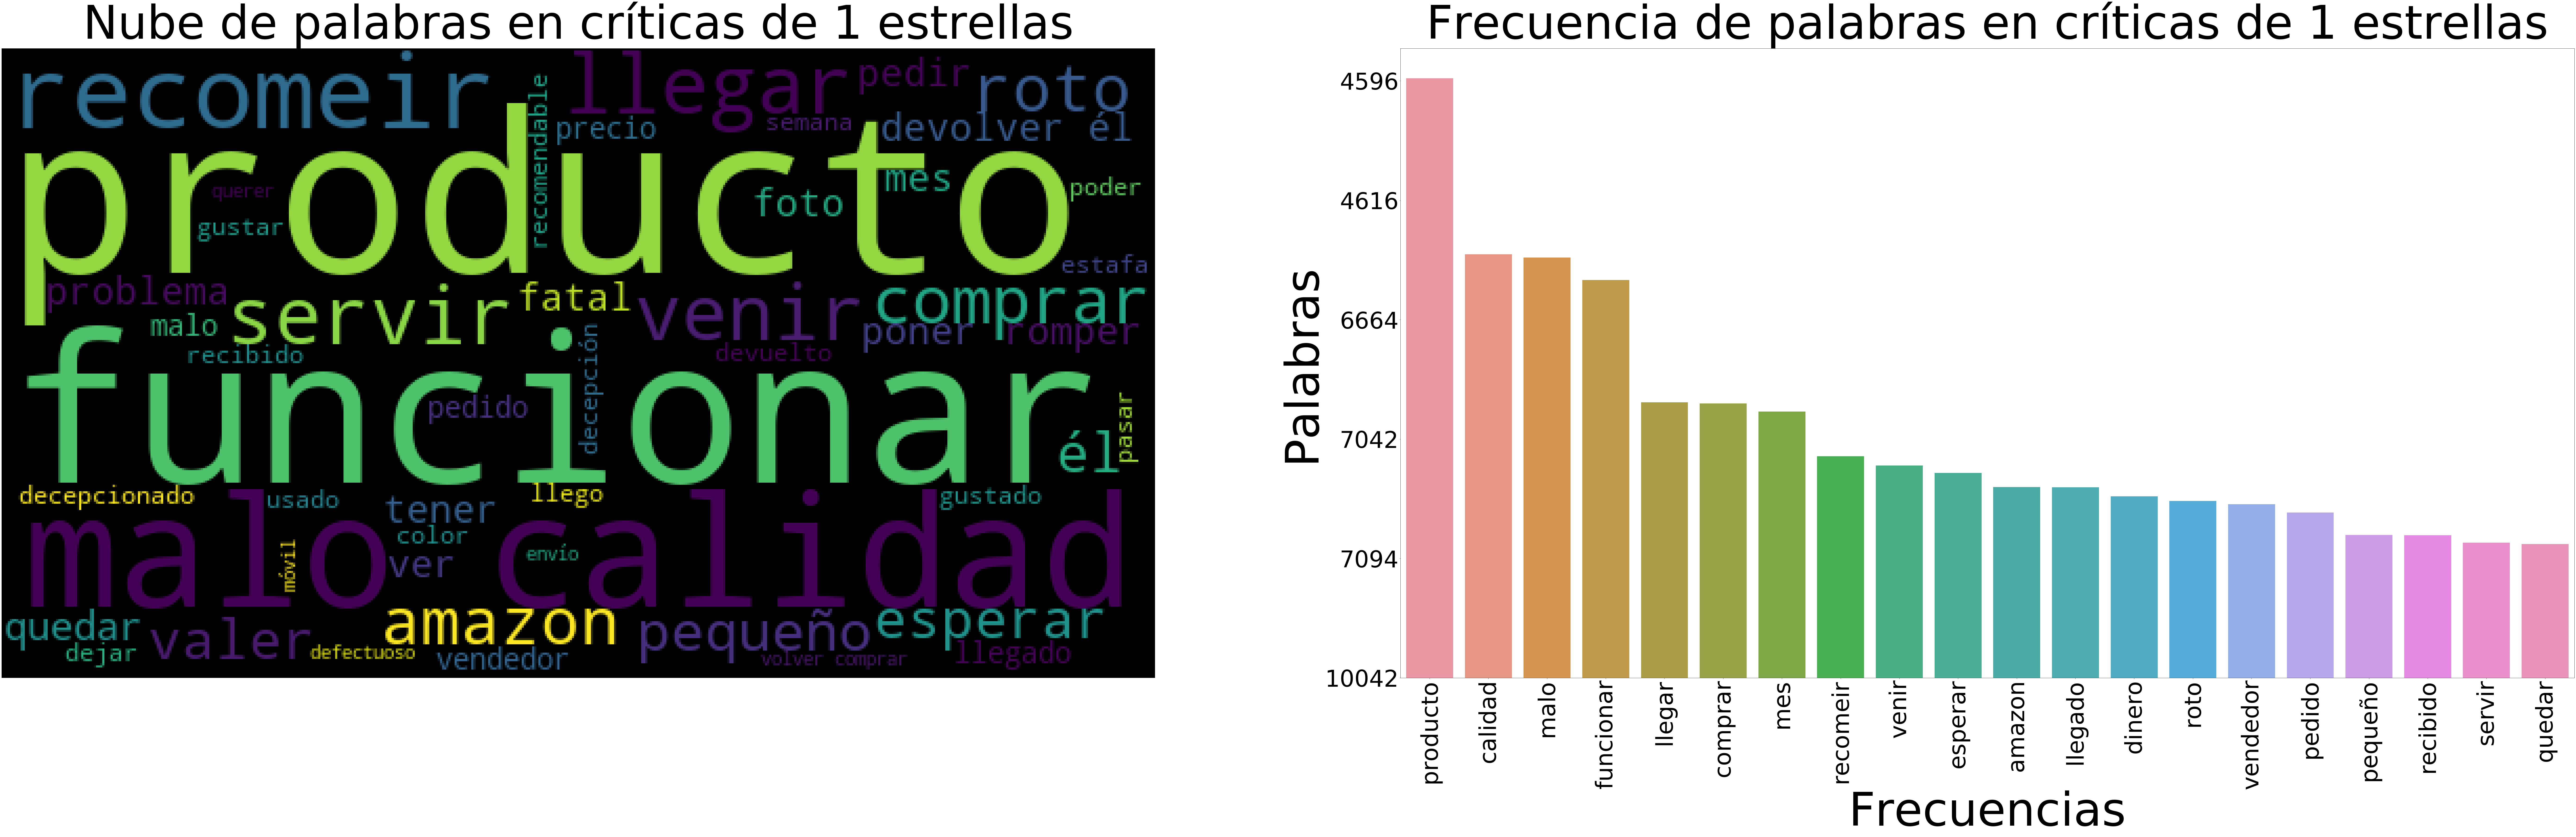

-------------
5 palabras más comunes para críticas de 2 estrellas
    Palabras  Frecuencia
0    calidad        9323
1   producto        6158
2  funcionar        4717
3    pequeño        4591
4       malo        4591
-------------


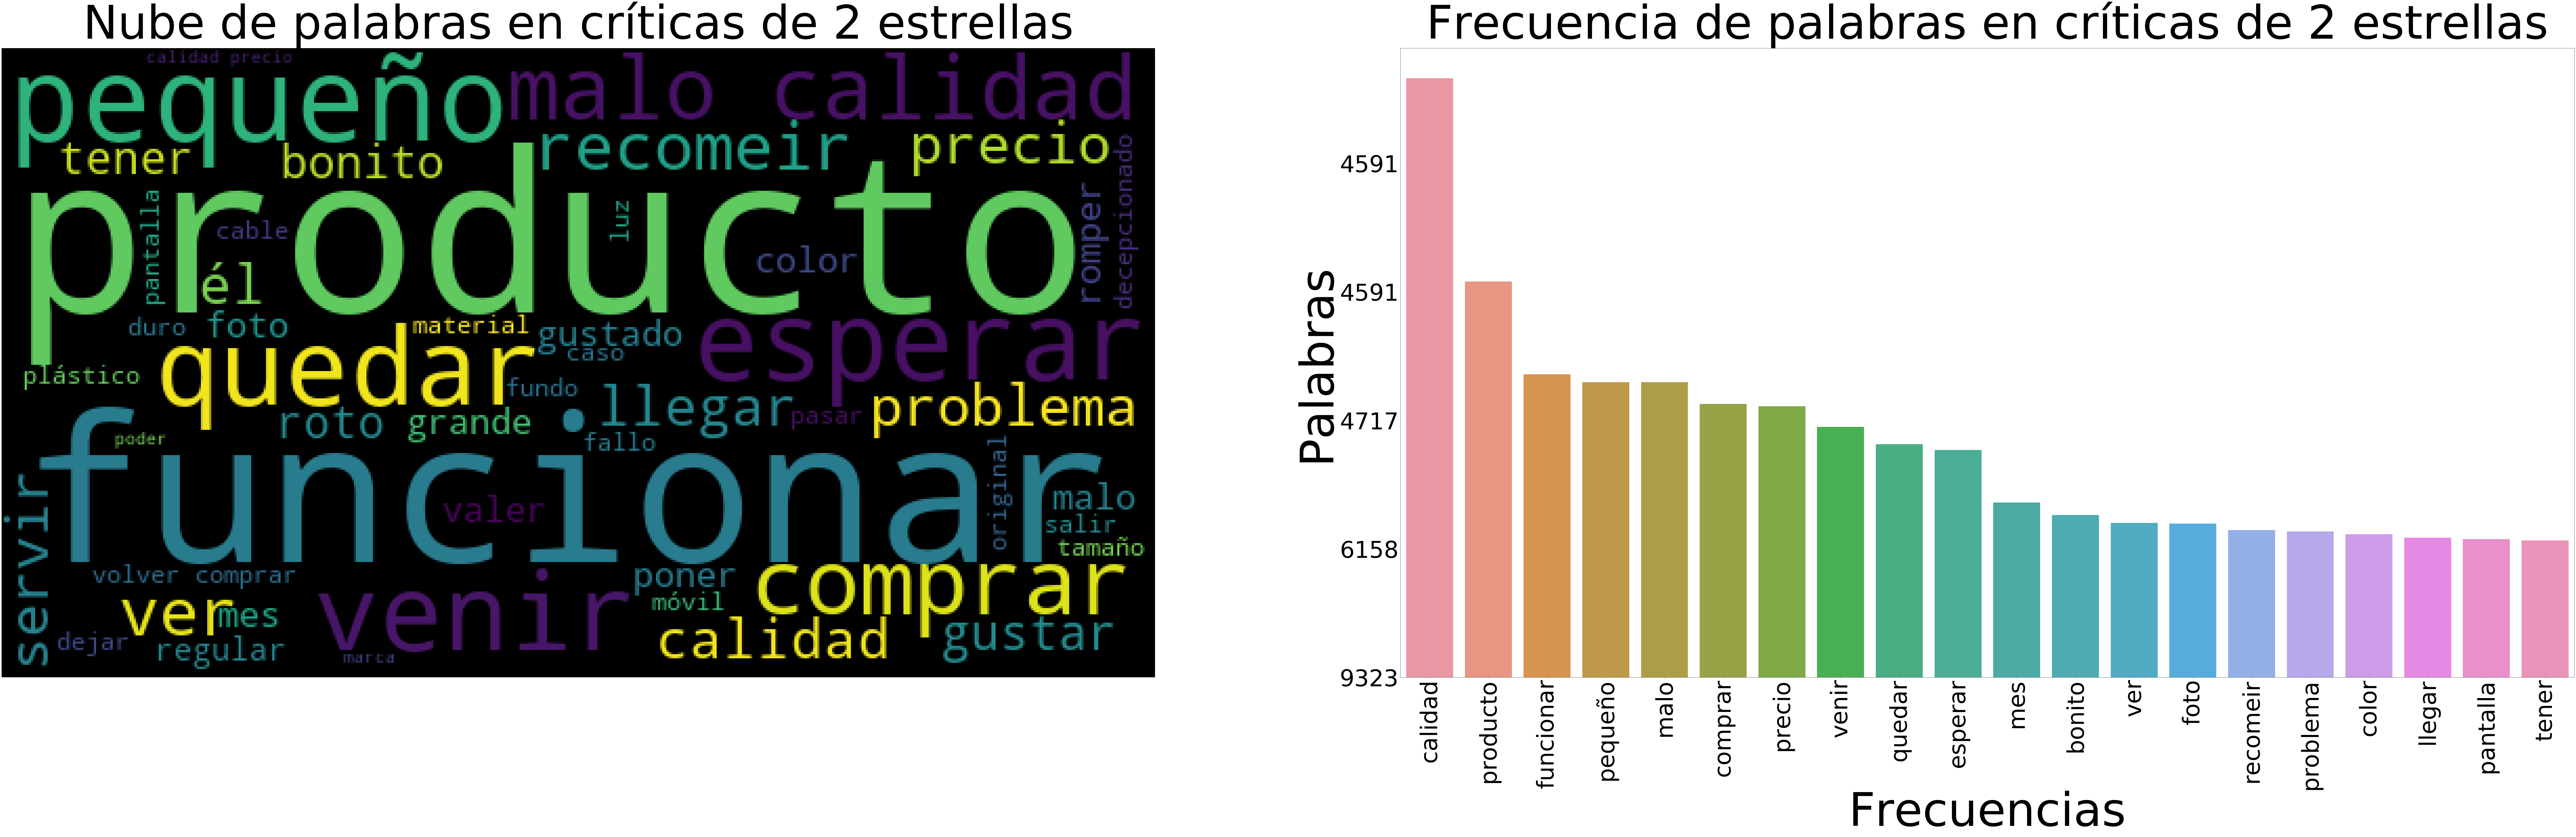

-------------
5 palabras más comunes para críticas de 3 estrellas
   Palabras  Frecuencia
0   calidad        8975
1    precio        7709
2  producto        5494
3   pequeño        4967
4   esperar        3608
-------------


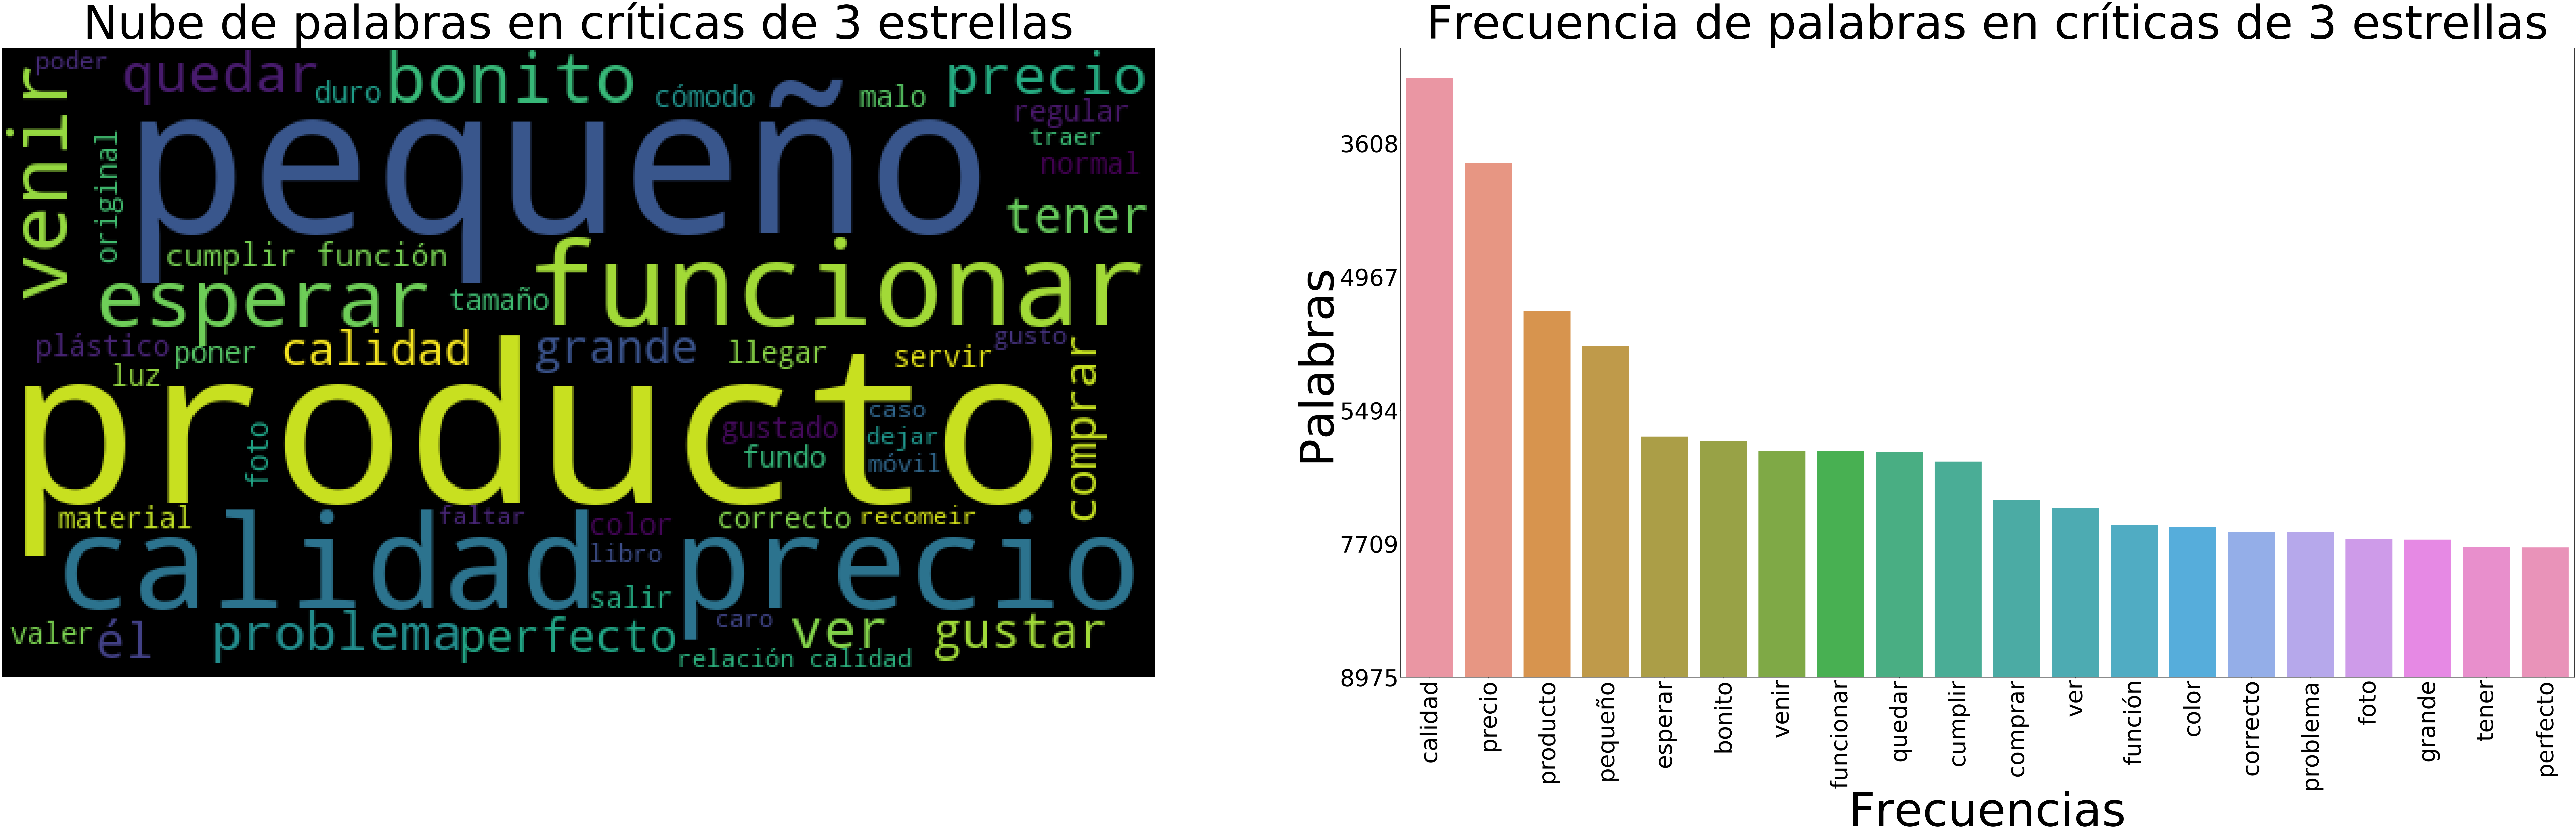

-------------
5 palabras más comunes para críticas de 4 estrellas
   Palabras  Frecuencia
0   calidad       11928
1    precio       11050
2  producto        6728
3  perfecto        5371
4   cumplir        4862
-------------


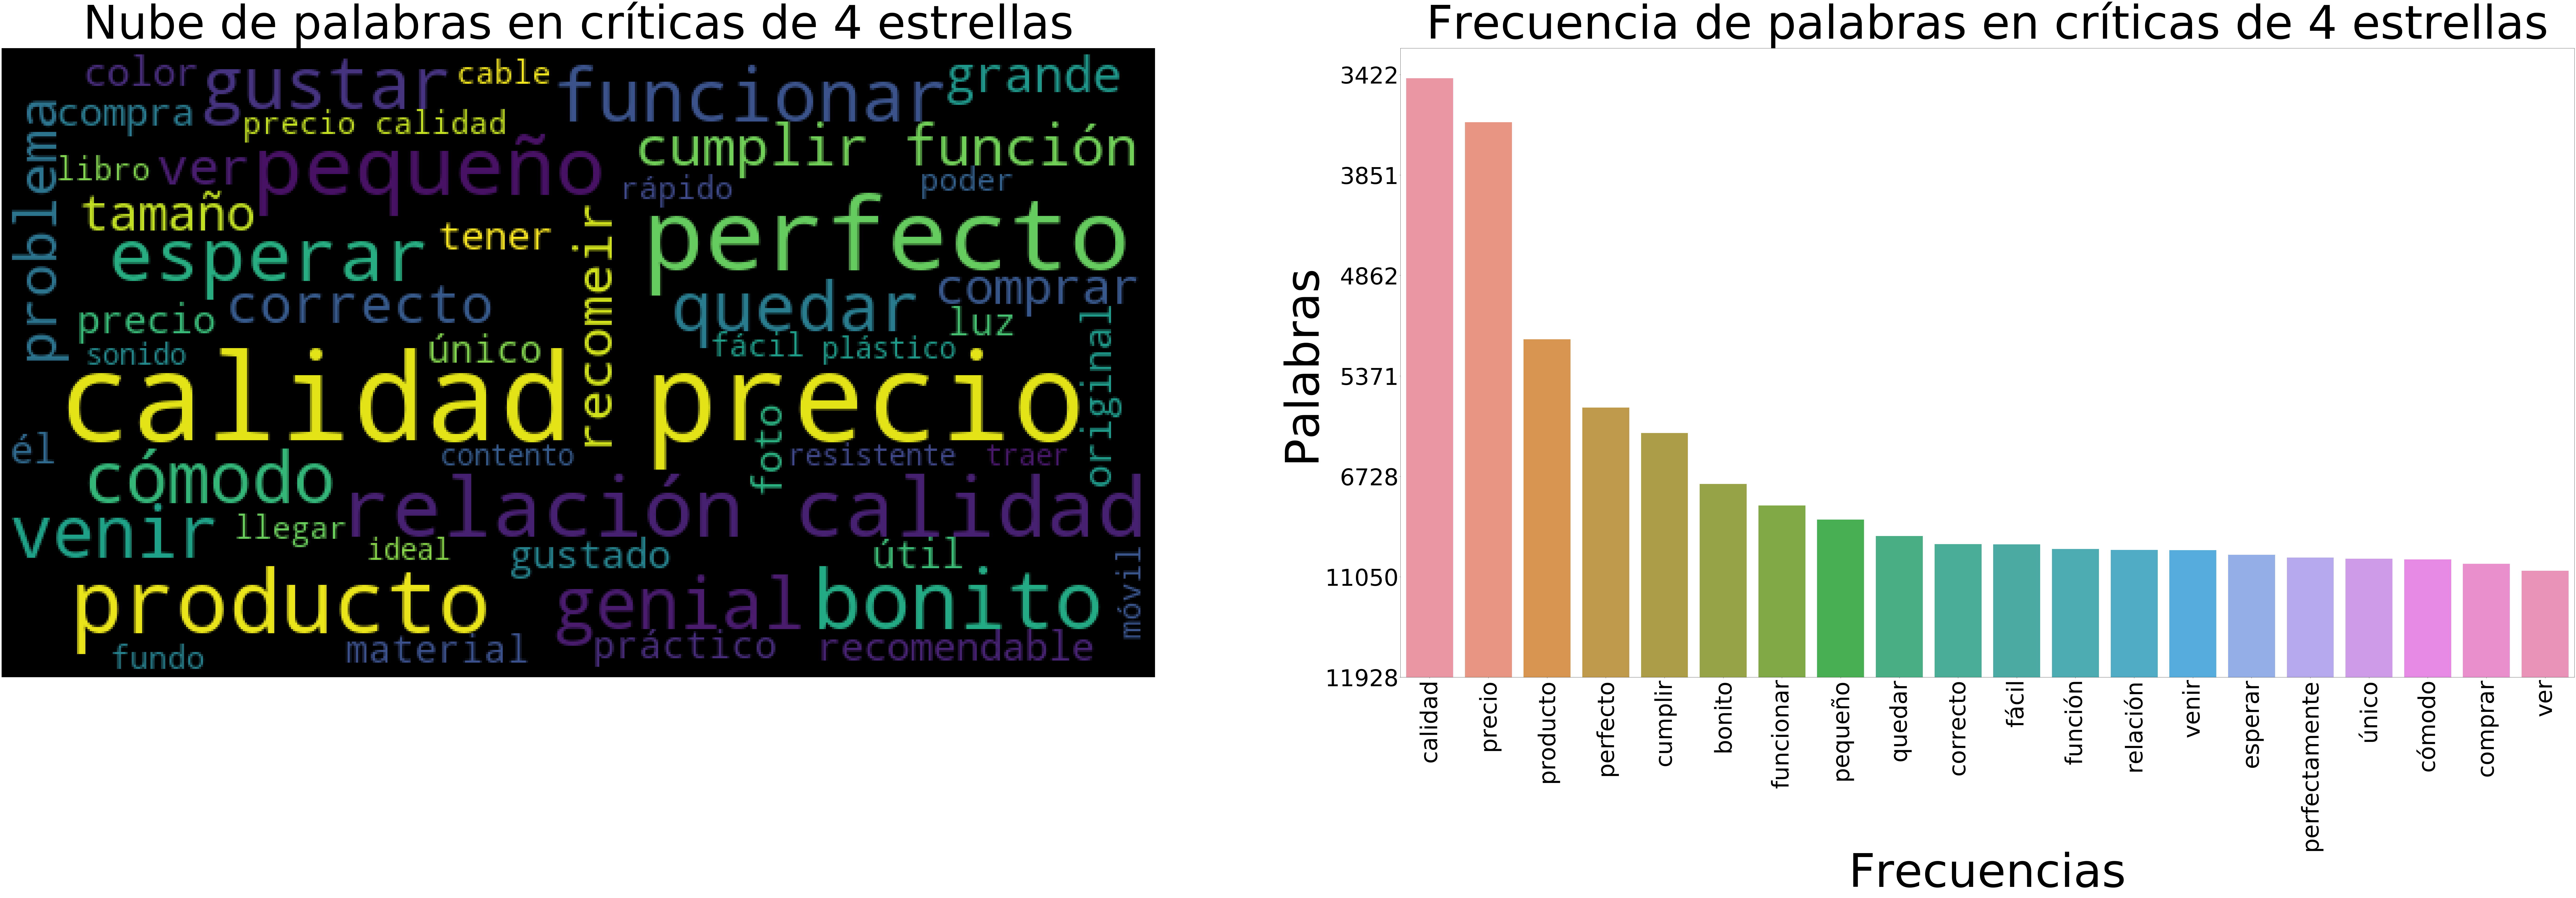

-------------
5 palabras más comunes para críticas de 5 estrellas
   Palabras  Frecuencia
0   calidad       12779
1  perfecto       11312
2    precio        8667
3  producto        6920
4    genial        4083
-------------


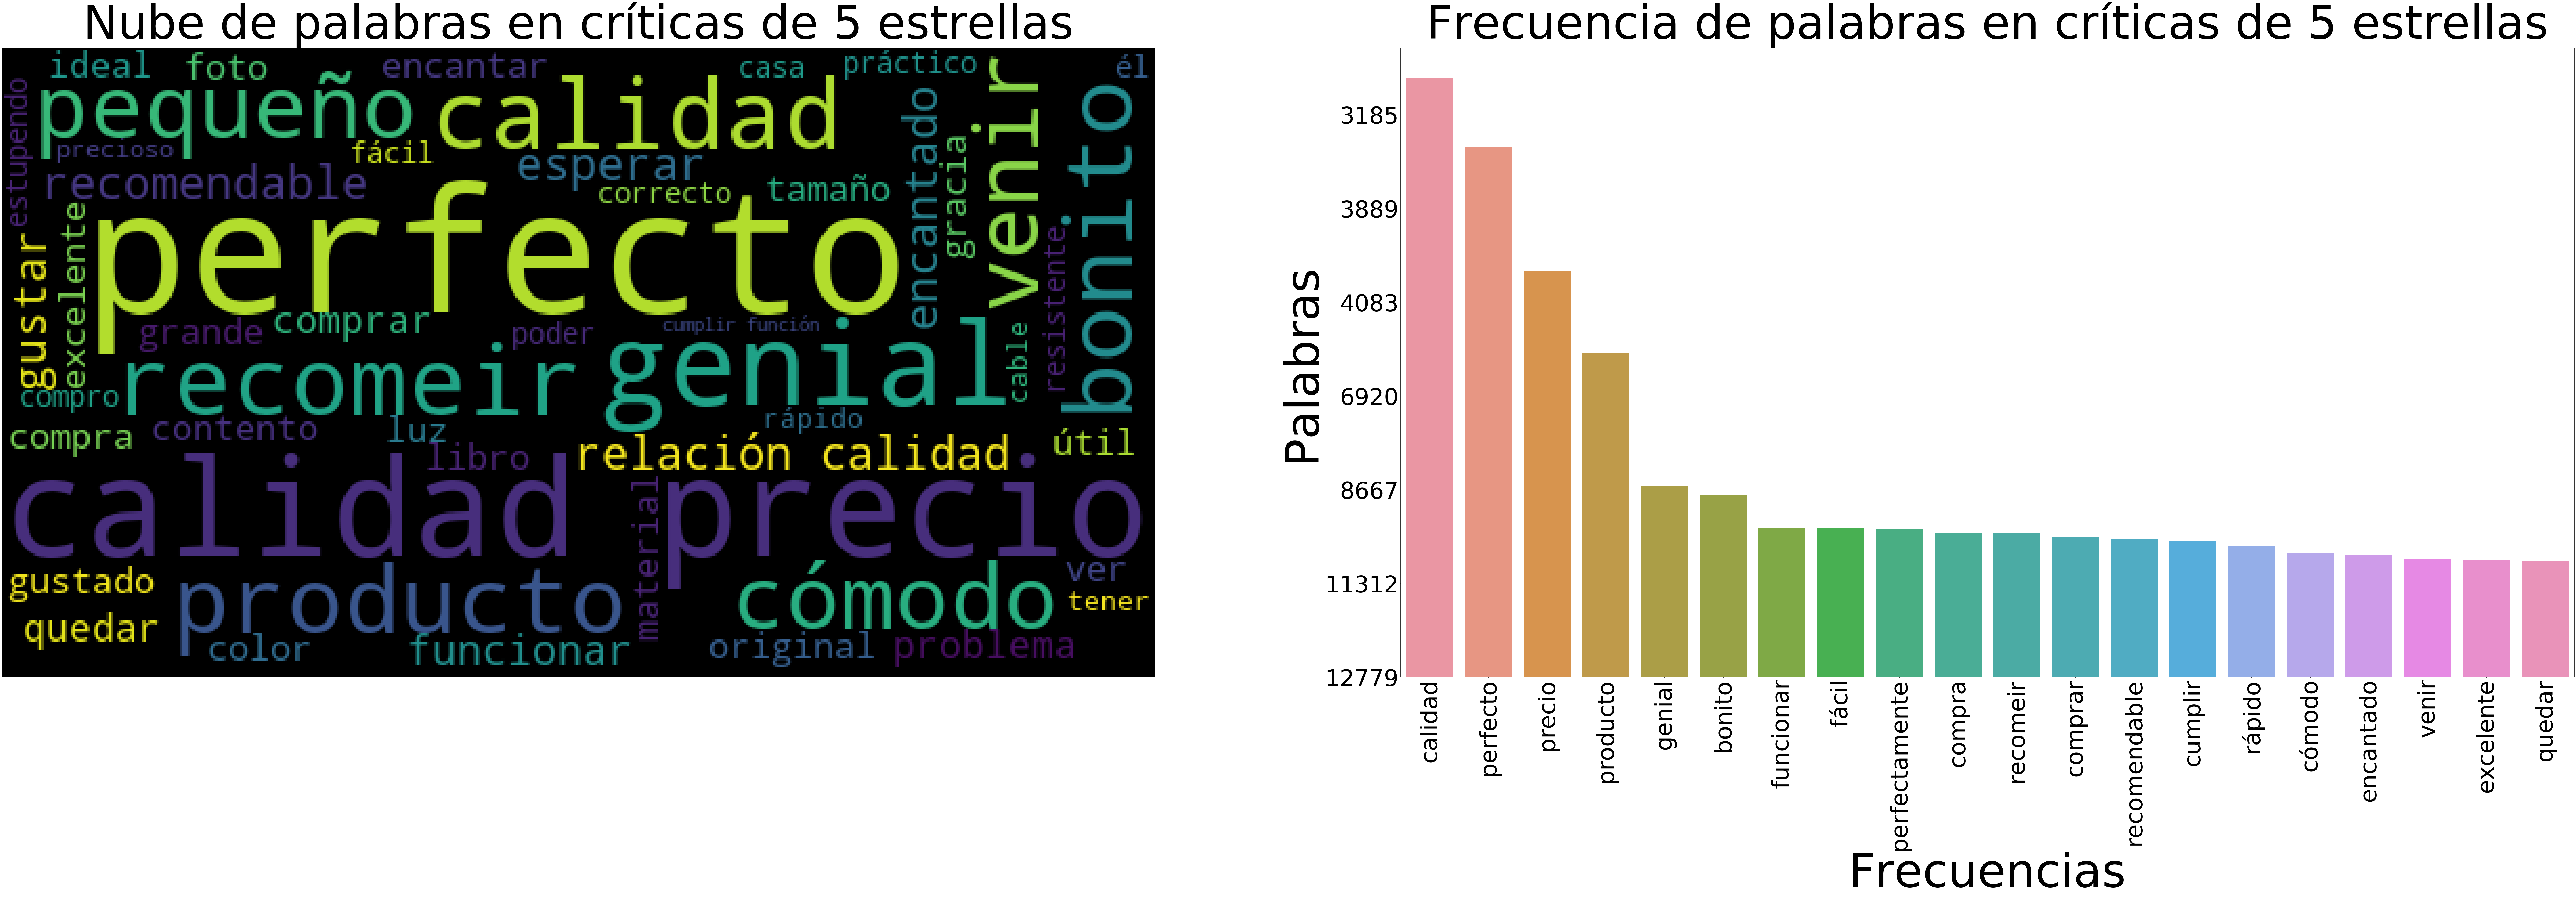

-------------


In [18]:
for x in range(1,6):
    tokenizado_df = df_amazon[df_amazon['stars']==x]
    tokenizado_lista = tokenizado_df.review_entero_tk.tolist()

    lista = [x for l in tokenizado_lista for x in l]

    frecuencia_palabras = Counter(lista)
    palabras_comunes = frecuencia_palabras.most_common()
    
    print(f'5 palabras más comunes para críticas de {x} estrellas')
    df_frec = pd.DataFrame(palabras_comunes, columns = ['Palabras', 'Frecuencia'])
    print(df_frec.head(5))
    print('-------------')
    
    tamaño_graficos = (200,50)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=tamaño_graficos)
    ax1 = plt.subplot(121)
    u_string=(" ").join(lista)
    wc = WordCloud(max_words = 50,width=tamaño_graficos[0]+350,height=tamaño_graficos[1]+250).generate(u_string)
    ax1.imshow(wc)
    ax1.axis("off")
    ax1.set_title(f'Nube de palabras en críticas de {x} estrellas', fontsize=200)

    ax2 = plt.subplot(122)
    ax2 = sns.barplot(ax=ax2,x = df_frec.iloc[:20].Palabras, y = df_frec.iloc[:20].Frecuencia)
    ax2.set_xticklabels(df_frec.iloc[:20].Palabras,fontsize = 100,rotation=90)
    ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)
    ax2.set_ylabel('Palabras',fontsize=200)
    ax2.set_xlabel('Frecuencias',fontsize=200)
    ax2.figure.set_size_inches(tamaño_graficos[0],tamaño_graficos[1])
    ax2.set_title(f'Frecuencia de palabras en críticas de {x} estrellas',fontsize=200)
    ax2.axis("on")
    plt.show()    
    
    print('-------------')

# B - Machine Learning

## Selección de métrica
En primer lugar, cabe aclarar que el problema se trata de encasillado de textos cortos en 5 escalas de valoración, tomando como entrada una reseña y devolviendo a partir de ella una predicción sobre cuál será el puntaje dado por el usuario para la compra hecha. Se trata, entonces, de un caso de **clasificación**.

Como se puede observar en la celda nº 8, existen igual cantidad de reseñas para cada nivel de estrellas, lo que implica que el dataset está perfectamente balanceado. Para este tipo de casos, se suele recomendar la utilización de la métrica <code>**Accuracy**</code> (exactitud)
. Además, también graficaré la <code>**Matriz de confusión**</code> de cada modelo para poder visualizar de qué forma los diferentes modelos clasifican los comentarios de diferentes escalas.

## Transformaciones

Trabajaré con los datasets provistos inicialmente. Estos son:
- <code>**df**</code>
- <code>**df_test**</code>
- <code>**df_train**</code>

In [19]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

Para facilitar el tratamiento de datos, uniré las reseñas con sus títulos en una misma columna (<code>reseña_entera</code>), pasando el texto a minúsculas, eliminando los atributos <code>review_body</code> y <code>review_title</code> que contienen esta información por separado y descartando todas las otras columnas

In [20]:
df['reseña_entera'] = df['review_title'] + ' ' + df['review_body']
df['reseña_entera'] = df['reseña_entera'].str.lower()
df = df.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id','product_category', 'review_body', 'review_title'])

df_test['reseña_entera'] = df_test['review_title'] + ' ' + df_test['review_body']
df_test['reseña_entera'] = df_test['reseña_entera'].str.lower()
df_test = df_test.drop(columns=['language', 'review_id', 'product_id','product_category', 'reviewer_id', 'review_body', 'review_title'])

df_train['reseña_entera'] = df_train['review_title'] + ' ' + df_train['review_body']
df_train['reseña_entera'] = df_train['reseña_entera'].str.lower()
df_train = df_train.drop(columns=['language', 'review_id', 'product_id','product_category', 'reviewer_id', 'review_body', 'review_title'])

In [21]:
df_train.head(5)

stars                                      reseña_entera
0      1  television nevir nada bueno se me fue ka panta...
1      1  dinero tirado a la basura con esta compra horr...
2      1  solo llega una unidad cuando te obligan a comp...
3      1  producto no recibido. no entro en descalificar...
4      1      devuelto llega tarde y co la talla equivocada

Aplico el procesamiento a los 3 dataframes por separado

In [22]:
df['reseña_entera_tk'] = df.apply(lambda row: procesar(row['reseña_entera']), axis=1)
df_test['reseña_entera_tk'] = df_test.apply(lambda row: procesar(row['reseña_entera']), axis=1)
df_train['reseña_entera_tk'] = df_train.apply(lambda row: procesar(row['reseña_entera']), axis=1)

Guardaré nuevamente los resultados en archivos <code>**.xlsx**</code> a modo de checkpoint

In [23]:
df.to_excel('ml_df.xlsx')
df_test.to_excel('ml_df_test.xlsx')
df_train.to_excel('ml_df_train.xlsx')

In [24]:
df.head(5)

stars                                      reseña_entera  \
0      1  mala compra malisimo, muy grande demasiado apa...   
1      1  no lo he recibido no he recibido el pedido no ...   
2      1  que no aprieta bien en el manillar tengo que b...   
3      1  brocas de mantequilla utilicé las brocas de me...   
4      1  no me gusta no me gusta su olor a viejo y aspe...   

                                    reseña_entera_tk  
0  [malo, compra, malisimo, grande, aparatoso, pr...  
1           [recibido, recibido, pedido, devolución]  
2  [aprieta, manillar, buscar, sistema, funcionar...  
3  [broca, mantequillar, utilicé, broca, menor, d...  
4        [gustar, gusta, olor, viejo, aspecto, malo]

In [25]:
df['reseña_entera_tk'] = df['reseña_entera'].apply(str)
df_test['reseña_entera_tk'] = df_test['reseña_entera'].apply(str)
df_train['reseña_entera_tk'] = df_train['reseña_entera'].apply(str)

In [26]:
df.head(4)

stars                                      reseña_entera  \
0      1  mala compra malisimo, muy grande demasiado apa...   
1      1  no lo he recibido no he recibido el pedido no ...   
2      1  que no aprieta bien en el manillar tengo que b...   
3      1  brocas de mantequilla utilicé las brocas de me...   

                                    reseña_entera_tk  
0  mala compra malisimo, muy grande demasiado apa...  
1  no lo he recibido no he recibido el pedido no ...  
2  que no aprieta bien en el manillar tengo que b...  
3  brocas de mantequilla utilicé las brocas de me...

A continuación, vectorizaré el texto a través del factor de ponderación <code>**Tf-idf**</code>. Este determina la relevancia de una palabra a partir de la frecuencia con la que aparece en un documento presente en una colección de documentos.

Al tener en cuenta la frecuencia *inversa* dentro de la colección de documentos, este ponderador puede atenuar el efecto que produce que algunas palabras sean más comunes en la misma. Así, en una colección de reseñas sobre, por ejemplo, infusiones, el ponderador reducirá el peso de la palabra "café" ya que es de esperarse que sea una palabra frecuente en la colección de reseñas.

Un peso alto en <code>**Tf-idf**</code> se alcanza con una elevada frecuencia de término (en la reseña dada) y una pequeña frecuencia de ocurrencia del término en la colección completa de reseñas

In [27]:
lista_reseñas_test = list(df_test['reseña_entera_tk'].values)
calif_test = df_test['stars'].values

lista_reseñas_train = list(df_train['reseña_entera_tk'].values)
calif_train = df_train['stars'].values 

lista_reseñas = list(df['reseña_entera_tk'].values)
calif = df['stars'].values 

#TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,1),max_features=1000, min_df=30)

#Transformo en matriz
matriz_reseña_test= tfidf.fit_transform(lista_reseñas_test)
matriz_reseña_train = tfidf.transform(lista_reseñas_train)
matriz_reseña = tfidf.transform(lista_reseñas)

print('Train', matriz_reseña_train.shape)
print('Test', matriz_reseña_test.shape)
print('Data', matriz_reseña.shape)

Train (200000, 524)
Test (5000, 524)
Data (5000, 524)


In [28]:
matriz_reseña_train = matriz_reseña_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_reseña_test = matriz_reseña_test.astype('float32')
calif_test= calif_test.astype('int8')

matriz_reseña = matriz_reseña.astype('float32')
calif= calif.astype('int8')

In [29]:
#TRAIN
X_train = matriz_reseña_train.toarray()
y_train = calif_train

#TEST
X_test = matriz_reseña_test.toarray()
y_test = calif_test

#DATA
X = matriz_reseña.toarray()
y = calif

## Entrenamiento de modelos

A continuación, entrenaré un modelo Naive-Bayes y lo consideraré modelo base para comparar su rendimiento con distintos modelos de clasificación

In [30]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Probaré distintos modelos de ML para ver sus rendimientos

In [31]:
random_forest = RandomForestClassifier(max_depth=50, 
                                       random_state=50)
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [32]:
svc = LinearSVC(C = 1, random_state=50)
svc.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=50, tol=0.0001,
          verbose=0)

## Predicciones y resultados

In [33]:
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))

Accuracy train NB:  0.45098
Accuracy test NB:  0.4518


In [34]:
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

print("Accuracy train Random Forest: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test Random Forest: ", accuracy_score(y_test, y_test_pred_rf))

Accuracy train Random Forest:  0.947195
Accuracy test Random Forest:  0.5032


In [35]:
y_train_pred_svc= svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred_svc))

Accuracy train LinearSVC:  0.525995
Accuracy test LinearSVC:  0.5252


El modelo que presenta mayor accuracy en test es el de <code>LinearSVC</code>. El hecho que Random Forest presente una marcada mayor precisión sobre el dataset de *entrenamiento* pero no sobre el de *prueba* revela que este presenta **overfitting**

A continuación, graficaré las matrices de confusión para los modelos seleccionados

Modelo: Naive-Bayes


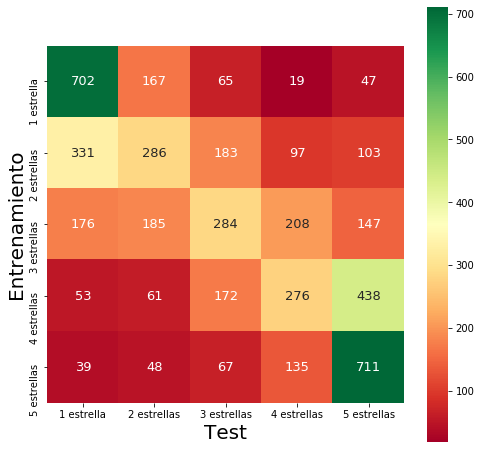

Modelo: Random Forest


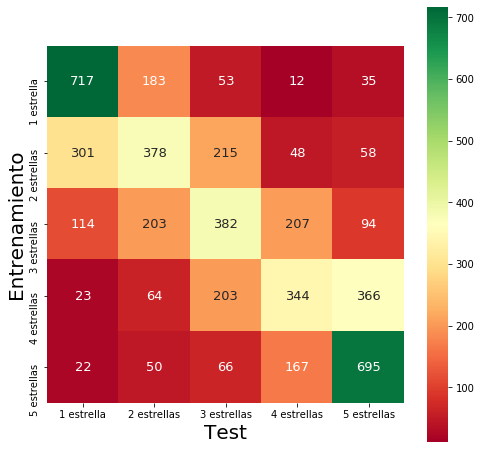

Modelo: SVC


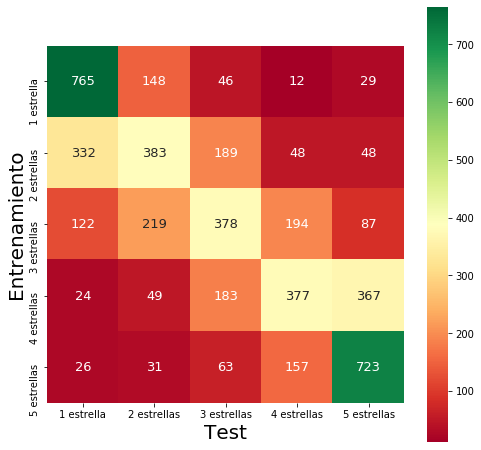

In [36]:
lista_modelos = ([y_test_pred,'Naive-Bayes'],[y_test_pred_rf,'Random Forest'],[y_test_pred_svc,'SVC'])

for i in range(0,3):
    print('Modelo: '+lista_modelos[i][1])
    calificacion=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm = confusion_matrix(y_test,lista_modelos[i][0])
    f,ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

    plt.xlabel("Test", size =20)
    plt.ylabel("Entrenamiento", size =20)
    ax.set_xticklabels(calificacion)
    ax.set_yticklabels(calificacion)
    plt.show()

Puedo concluir a partir de estos resultados que <code>Random Forest</code> es el que mejor predice resultados intermedios (**3 estrellas**), mientras que los otros 2 cuentan con mayor precisión en las reseñas con una tendencia más marcada (**1 ó 5 estrellas**).

Sin embargo, la precisión es ligeramente mejor en el <code>LinearSVC</code>, además de que en el de <code>Random Forest</code> existe overfitting, por lo que el mejor modelo sigue siendo el primero. Podemos observar, además, que el modelo <code>LinearSVC</code> prácticamente confunde las reseñas de 4 con las de 5 estrellas.

La dificultad para diferenciar reseñas que no se encuentran en los extremos de puntajes se puede corroborar en las nubes de palabras, donde la mayoría de las palabas utilizadas son comunes para las reseñas entre 2 y 4 estrellas, mientras que en las más extremas presentan palabras particulares, como "malo" o "excelente".

## Optimización

Un primer vistazo a la forma en la que fueron tratados los datos nos permite observar que a la hora de vectorizar, el ponderador <code>Tf-idf</code> sólo tiene en cuenta las palabras en unigramas, esto es, de a una (a través del hiperparámetro <code>**ngram_range = (1,1)**</code>).

Se podría mejorar el rendimiento de los modelos tomando hasta tríos de palabras, o trigramas ya que pueden capturar expresiones más complejas como "muy buena calidad", en vez de "muy", "bueno" y "calidad" por separado, ya que, sin contexto, las palabras "muy" y "calidad" pueden resultar neutras, mientras que la expresión en su conjunto puede ser un muy buen predictor de un puntaje de 5 estrellas

In [37]:
lista_reseñas_test = list(df_test['reseña_entera_tk'].values)
calif_test2 = df_test['stars'].values

lista_reseñas_train = list(df_train['reseña_entera_tk'].values)
calif_train2 = df_train['stars'].values 

lista_reseñas = list(df['reseña_entera_tk'].values)
calif2 = df['stars'].values 

#TfidfVectorizer
tfidf2 = TfidfVectorizer(ngram_range=(1, 3), max_features=1000, min_df=30)

#Transformo en matriz
matriz_reseña_test2= tfidf2.fit_transform(lista_reseñas_test)
matriz_reseña_train2 = tfidf2.transform(lista_reseñas_train)
matriz_reseña2 = tfidf2.transform(lista_reseñas)

print('Train', matriz_reseña_train2.shape)
print('Test', matriz_reseña_test2.shape)
print('Data', matriz_reseña2.shape)

Train (200000, 957)
Test (5000, 957)
Data (5000, 957)


In [38]:
matriz_reseña_train2 = matriz_reseña_train2.astype('float32')
calif_train2 = calif_train2.astype('int8')

matriz_reseña_test2 = matriz_reseña_test2.astype('float32')
calif_test2= calif_test2.astype('int8')

In [39]:
# Set de entrenamiento
X_train2 = matriz_reseña_train2.toarray()
y_train2 = calif_train2

# Test
X_test2 = matriz_reseña_test2.toarray()
y_test2 = calif_test2

In [40]:
# Reentrenamiento para los 3 modelos

nb.fit(X_train2,y_train2)
y_train_pred2 = nb.predict(X_train2)
y_test_pred2 = nb.predict(X_test2)

random_forest.fit(X_train2,y_train2)
y_train_pred_rf2 = random_forest.predict(X_train2)
y_test_pred_rf2 = random_forest.predict(X_test2)

svc.fit(X_train2, y_train2)
y_train_pred_svc2= svc.predict(X_train2)
y_test_pred_svc2 = svc.predict(X_test2)

In [41]:
# Nuevamente imprimo resultados
print('Tf-idf unigrama')
print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))
print('--------------------------')
print("Accuracy train RF: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test RF: ", accuracy_score(y_test, y_test_pred_rf))
print('--------------------------')
print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))
print(" ")

print('Tf-idf trigrama')
print("Accuracy train NB: ", accuracy_score(y_train2, y_train_pred2))
print("Accuracy test NB: ", accuracy_score(y_test2, y_test_pred2))
print('--------------------------')
print("Accuracy train RF: ", accuracy_score(y_train2, y_train_pred_rf2))
print("Accuracy test RF: ", accuracy_score(y_test2, y_test_pred_rf2))
print('--------------------------')
print("Accuracy train LinearSVC: ", accuracy_score(y_train2, y_train_pred_svc2))
print("Accuracy test LinearSVC: ", accuracy_score(y_test2, y_test_pred_svc2))

Tf-idf unigrama
Accuracy train NB:  0.45098
Accuracy test NB:  0.4518
--------------------------
Accuracy train RF:  0.947195
Accuracy test RF:  0.5032
--------------------------
Accuracy train SVC:  0.525995
Accuracy test SVC:  0.5252
 
Tf-idf trigrama
Accuracy train NB:  0.48041
Accuracy test NB:  0.4796
--------------------------
Accuracy train RF:  0.92222
Accuracy test RF:  0.5066
--------------------------
Accuracy train LinearSVC:  0.54273
Accuracy test LinearSVC:  0.5316


Se puede observar que la mejora es marginal, por lo que intentaré recurrir a la optimización de hiperparámetros del modelo de mejor rendimiento (<code>LinearSVC</code>) mediante <code>**GridsearchCV**</code>, en la cual se prueban todas las combinaciones posibles del diccionario que paso a través de la variable <code>parametros</code>

In [42]:
X_train_tfidfopt = X_train2.copy()
y_train_tfidfopt = y_train2.copy()
X_test_tfidfopt = X_train2.copy()
y_test_tfidfopt = y_train2.copy()

In [43]:
svc_opt = LinearSVC() 

parametros =  {'C': [0.001, 10, 25, 100, 500],
                'penalty':['l1','l2'],
                'tol': [1e-2, 1e-4],
                'loss': ['hinge', 'squared_hinge']}              


CV_svc = GridSearchCV(estimator=svc_opt, param_grid=parametros, cv= 2)
CV_svc.fit(X_train_tfidfopt, y_train_tfidfopt)
print(CV_svc.best_params_)

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

{'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.01}


In [44]:
svc_opt = LinearSVC(C=10,loss='squared_hinge',penalty='l2',tol = 0.01) 

svc_opt.fit(X_train_tfidfopt, y_train_tfidfopt)

y_train_pred_opt = svc_opt.predict(X_train_tfidfopt)
y_test_pred_opt = svc_opt.predict(X_test_tfidfopt)

print("Accuracy train LinearSVC sin optimizar: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test LinearSVC: sin optimizar", accuracy_score(y_test, y_test_pred_svc),'\n')

print('--------------\n')

print("Accuracy train LinearSVC optimizado: ", accuracy_score(y_train_tfidfopt, y_train_pred_opt))
print("Accuracy test LinearSVC: optimizado", accuracy_score(y_test_tfidfopt, y_test_pred_opt))

Accuracy train LinearSVC sin optimizar:  0.525995
Accuracy test LinearSVC: sin optimizar 0.5252 

--------------

Accuracy train LinearSVC optimizado:  0.54279
Accuracy test LinearSVC: optimizado 0.54279


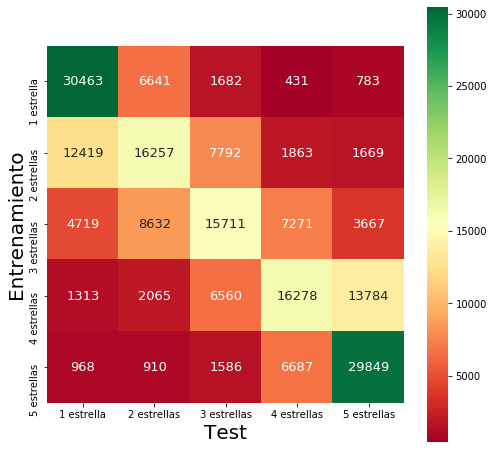

In [45]:
calificacion=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
cm = confusion_matrix(y_test_tfidfopt,y_test_pred_opt)
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

plt.xlabel("Test", size =20)
plt.ylabel("Entrenamiento", size =20)
ax.set_xticklabels(calificacion)
ax.set_yticklabels(calificacion)
plt.show()

Por último, y para visualizar de mejor forma las palabras o frases de 3 estrellas cuya presencia o ausencia define la clasificación en los distintos rangos, graficaré la importancia de cada una:

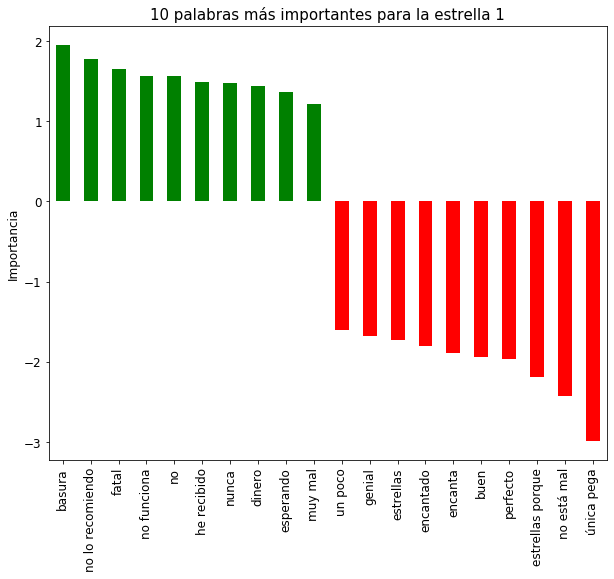

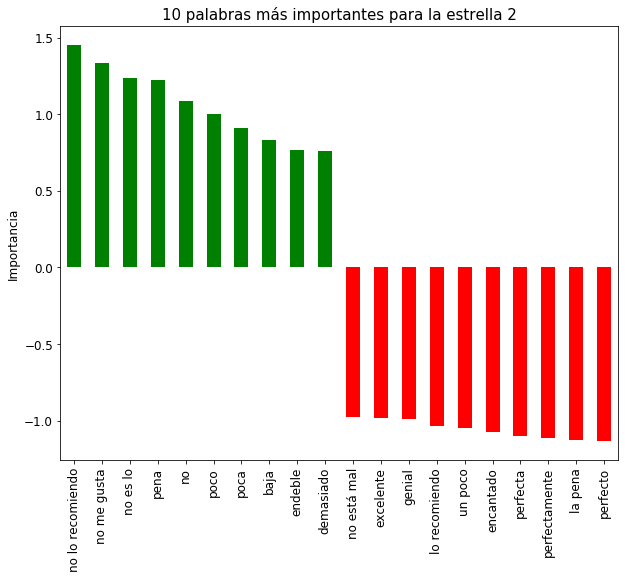

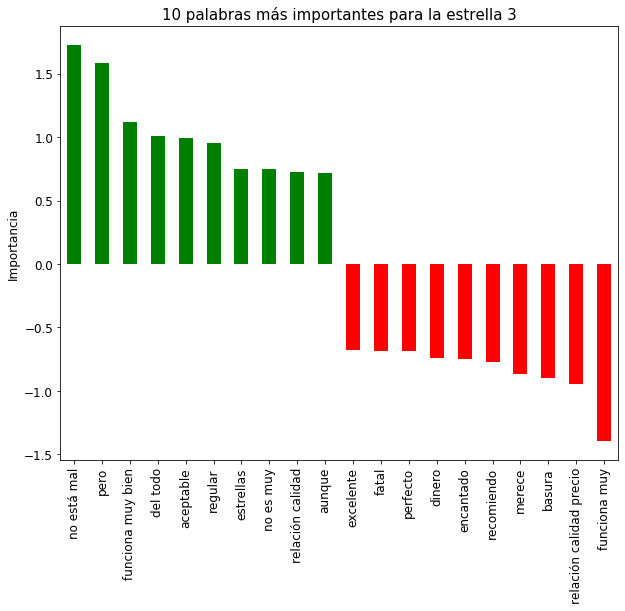

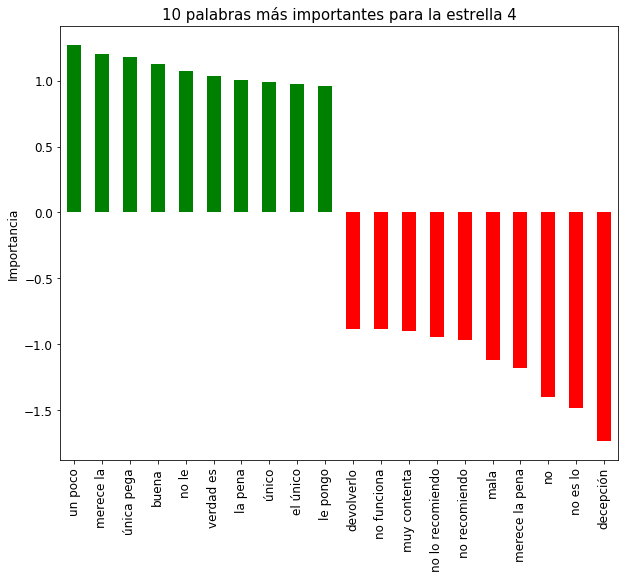

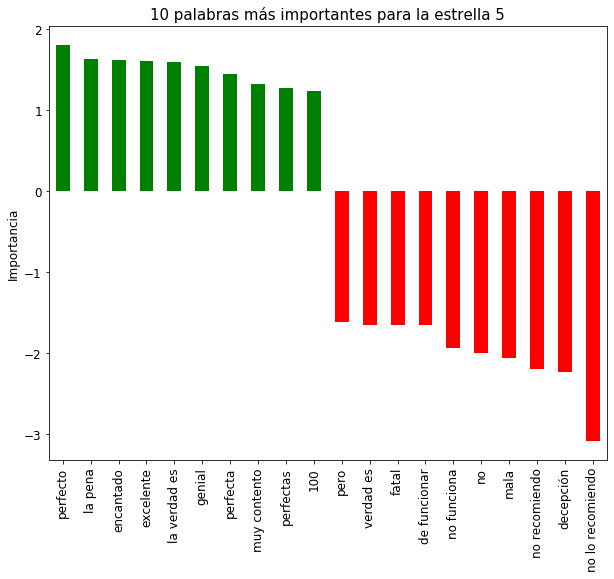

In [52]:
todas_palabras = tfidf2.get_feature_names()

for x in range (0,5):
    coef = list(svc_opt.coef_[x])
    etiqueta = list(todas_palabras)
    palabras = pd.DataFrame()
    palabras['Features'] = etiqueta
    palabras['Importancia'] = coef
    features = palabras.reset_index(drop=True)
    palabras_ordenadas = features.sort_values(by=['Importancia'], ascending=False)
    palabras_ordenadas = palabras_ordenadas.reset_index(drop=True)
    data_plot = pd.concat([palabras_ordenadas.head(10), palabras_ordenadas.tail(10)])
    data_plot.sort_values(by=['Importancia'], ascending=False, inplace = True)
    data_plot['positive'] = data_plot['Importancia'] > 0
    data_plot.set_index('Features', inplace = True)
    data_plot.Importancia.plot(kind='bar', figsize = (10,8),
                              color = data_plot.positive.map({True: 'green', False: 'red'}),
                              fontsize=12)
    plt.xlabel ('', fontsize=12)
    plt.ylabel ('Importancia', rotation = 90, fontsize=12)
    plt.title ('10 palabras más importantes para la estrella ' + str(x+1), fontsize=15)
    plt.show()

# C - Conclusiones

Podemos concluir que el rendimiento mejoró muy poco tanto con el ajuste del Tf-idf como con la optimización de hiperparámetros del modelo <code>LinearSVC</code>. De la matriz de confusión vemos que la capacidad de predecir 4 estrellas mejoró un poco hasta casi igualar el rendimiento de las de 2, a diferencia del no optimizado. Las reseñas de puntajes intermedios marcarán el techo del rendimiento del modelo, y más allá de una optimización rigurosa las ganancias a partir de cierto punto serán marginales.

Existirá siempre un límite a la capacidad de un modelo de Machine Learning de clasificar puntajes en una escala de 1 al 5. Esto se debe a una limitación inherente al lenguaje por la falta de palabras distintivas en las reseñas intermedias y porque estas suelen poseer tanto palabras malas como buenas. A continuación, imprimiré 3 reseñas aleatorias de puntajes 2, 3 y 4 estrellas para demostrar la dificultad de distinguirlas a simple vista.

In [46]:
for i in range(2,5):
    df1 = df.loc[df['stars']==i]
    indice_min = min(df1.index)
    indice_max = max(df1.index)
    print(f'3 reseñas de {i} estrellas:')
    for x in range(1,4):
        print(df1['reseña_entera'].loc[df['stars']==i][random.randint(indice_min,indice_max)])
    print('----------------')

3 reseñas de 2 estrellas:
muy caro y flojo no le voy a sacar el provecho que debería... es muy flojo para el tema del trabajo femenino. está bien por una parte, porque el trabajo femenino está de moda y llama mucho la atención, pero el libro es caro para el contenido... y es pesado de leer además...
muy mala calidad es de poca calidad y encima viene golpeada y retocada . no lo recomiendo para nada ,una decepción como producto.
no tapa nada queda muy cuqui con los colorines pero no tapa un carajo
----------------
3 reseñas de 3 estrellas:
la luz que parpadea las delata la luz parpadeando da la sensación de ser falsas, yo lo uso sin pilas.
la calidad los bajos buenos, los agudos justitos
calidad precio bueno se ajusta a lo que explican , he de decir que para una lg de 24” con los cables en la parte de abajo no es apta , como veis en la foto la placa que sujeta el televisor no da opción a poder conectar nada ,porque una vez que pones los tornillos queda tan pegada que no cabe un simple ca

Más allá de esto, la clasificación de las reseñas en 5 clases, dependiendo del uso de esta información, podría resultar trivial, ya que saber si un producto tiene 2 o 3 estrellas no aportaría información valiosa y accionable. Podría resultar más práctico y a la vez mejoraría en gran medida el rendimiento del modelo convertir este problema en una clasificación *binaria* (positiva/negativa).

Esto podría permitir en un futuro reemplazar el sistema de puntuaciones + reseña por uno que sólo permita reseñar, lo que permitiría evitar el sesgo del otorgamiento de puntajes, ya que cada usuario posee un concepto subjetivo personal de lo que considera 2 o 4 estrellas.

Me gustaría poder probar otros modelos y con más variaciones de hiperparámetros, pero encuentro la limitación de mi PC que no me permite realizar todas las pruebas que quisiera a la velocidad que quisiera por falta de capacidad de procesamiento.

A modo de experimento y para testear la calidad del modelo de primera mano, escribiré 10 reseñas ficticias sobre la compra de un televisor que comiencen con "Compré este televisor y..." para ser evaluadas y ver si las predicciones coinciden con el puntaje que suponía de antemano que merecían

In [60]:
reseña = ['Compré este televisor y sinceramente no lo recomiendo, la definición me resulta horrible',
         'Compré este televisor y me encantó',
          'Compré este televisor y la calidad de la imagen es mala',
          'Compré este televisor y me resulta muy bueno. Como punto a mejorar, me gustaría que los soportes no estén hechos de plástico porque me da miedo que se rompan',
         'Compré este televisor y la relación calidad precio es buena pero no me termina de convencer del todo',
         'Compré este televisor y pareció una basura',
          'Compré este televisor y es muy feo. Rescato su nitidez pero me resulta muy pesado y aparatoso',
         'Compré este televisor y su única pega es el precio',
         'Compré este televisor y la calidad podría ser mejor',
         'Compré este televisor y me siento un poco decepcionado porque algunos botones fallan pero la calidad es dentro de todo decente']
x=0
for i in reseña:
    matriz= tfidf2.transform(reseña)
    matriz = matriz.astype('float32')
    X = matriz.toarray()
    y_train_pred_prueba = svc_opt.predict(X)
    print(f'Reseña: {i}. Puntaje:',y_train_pred_prueba[x])
    x = x+1
    print('------------------')

Reseña: Compré este televisor y sinceramente no lo recomiendo, la definición me resulta horrible. Puntaje: 1
------------------
Reseña: Compré este televisor y me encantó. Puntaje: 5
------------------
Reseña: Compré este televisor y la calidad de la imagen es mala. Puntaje: 2
------------------
Reseña: Compré este televisor y me resulta muy bueno. Como punto a mejorar, me gustaría que los soportes no estén hechos de plástico porque me da miedo que se rompan. Puntaje: 5
------------------
Reseña: Compré este televisor y la relación calidad precio es buena pero no me termina de convencer del todo. Puntaje: 3
------------------
Reseña: Compré este televisor y pareció una basura. Puntaje: 1
------------------
Reseña: Compré este televisor y es muy feo. Rescato su nitidez pero me resulta muy pesado y aparatoso. Puntaje: 2
------------------
Reseña: Compré este televisor y su única pega es el precio. Puntaje: 4
------------------
Reseña: Compré este televisor y la calidad podría ser mejor. 

A excepción de la anteúltima reseña en la que el modelo no interpretó bien el significado de la expresión "podría ser mejor" y la cuarta en la cual el "punto a mejorar" y el "no me termina de convencer del todo" a mi criterio implicaban un puntaje de 3 a 4 estrellas, las predicciones coincidieron en gran medida con el puntaje que buscaba para cada reseña.

# D - PRÓXIMOS PASOS

En posteriores informes y a modo de ampliación de las conclusiones del presente trabajo, exploraré los resultados de aplicar un modelo de clasificación **binaria** (reseña positiva / negativa) al dataset.

Esto podría ser logrado entrenando un modelo que considere las reseñas de 1 y 2 estrellas como 1 (puntaje negativo) y las de 4 y 5 como 2 (puntaje positivo), descartando las de 3 estrellas para mantener el dataset balanceado.

Es de esperarse que la accuracy (exactitud) se reduzca drásticamente, ya que como podemos ver en la matriz de confusión, los modelos expuestos en el presente informe clasifican mal las reseñas de 2 estrellas en mayor medida como si fueran 1 y e interpreta las de 4 como si fueran de 5.

Además, este separaría las reseñas de 3 estrellas en positivas o negativas en vez de considerarlas neutras